## Code for plotting plausibility checks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

In [4]:
# Filter out invalid heart rate values (<= 0)
train = train[train['respiration_rate'] > 0]

# Find HR +2 std dev away from mean
rr_mean = train['respiration_rate'].mean()
rr_std = train['respiration_rate'].std()
rr_threshold = rr_mean + 2 * rr_std
print(f"Mean RR: {rr_mean}, Std Dev: {rr_std}, Threshold (Mean + 2*Std): {rr_threshold}")

Mean RR: 12.793016241641691, Std Dev: 4.252853758605424, Threshold (Mean + 2*Std): 21.29872375885254


In [5]:
# Round rr_threshold
rr_threshold = round(rr_threshold, 0)
rr_threshold

np.float64(21.0)

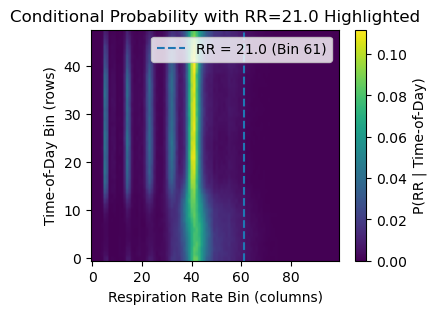

In [11]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def plot_tod_vs_feat(train, test, feature="respiration_rate", feat_value=107, colorlbl='P(HR | Time-of-Day)',
                   xlab = 'Heart Rate Bin (columns)', ylab = 'Time-of-Day Bin (rows)',
                   title = 'Conditional Probability with HR=107 Highlighted',
                   filename = 'Plausibility_HR107'):
    # 1) Angle in [0, 2π)
    train = train.copy()
    test  = test.copy()
    train['tod_angle'] = (np.arctan2(train['tod_sin'], train['tod_cos']) % (2*np.pi))
    test['tod_angle']  = (np.arctan2(test['tod_sin'],  test['tod_cos'])  % (2*np.pi))

    # 2) Filter HR>0 before binning
    train = train[train[feature] > 0]

    # 3) Define and REUSE bin edges
    T = 48  # time bins
    H = 100 # HR bins

    t_edges = np.linspace(0.0, 2*np.pi, T+1)  # fixed edges over full circle
    hr_min, hr_max = train[feature].min(), train[feature].max()
    hr_edges = np.linspace(hr_min, hr_max, H+1)

    # 4) Digitize both variables using the SAME edges everywhere
    t_idx = np.digitize(train['tod_angle'].to_numpy(), t_edges, right=False) - 1
    h_idx = np.digitize(train[feature].to_numpy(), hr_edges, right=False) - 1

    # Clip any boundary hits to valid [0, bins-1]
    t_idx = np.clip(t_idx, 0, T-1)
    h_idx = np.clip(h_idx, 0, H-1)

    # 5) Build count matrix with all bins present
    count_matrix = np.zeros((T, H), dtype=int)
    np.add.at(count_matrix, (t_idx, h_idx), 1)

    # 6) Conditional P(HR | time) = row-normalize
    row_sums = count_matrix.sum(axis=1, keepdims=True)
    prob_matrix = np.divide(count_matrix, np.where(row_sums==0, 1, row_sums), where=row_sums!=0)

    # 8) Highlight HR = 107 using the SAME hr_edges (vertical line, not horizontal)
    hr_bin = np.digitize([feat_value], hr_edges, right=False)[0] - 1
    hr_bin = int(np.clip(hr_bin, 0, H-1))

    plt.figure(figsize=(4, 3))
    plt.imshow(prob_matrix, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label=colorlbl)
    plt.axvline(x=hr_bin, linestyle='--', label=f'RR = {feat_value} (Bin {hr_bin})')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.savefig(f'./figures/{filename}.png', dpi=1000, bbox_inches="tight")
    plt.savefig(f'./figures/{filename}.pdf', bbox_inches="tight")
    plt.savefig(f'./figures/{filename}.svg', bbox_inches="tight")
    plt.show()

# Plot for RR
plot_tod_vs_feat(train, test, feature='respiration_rate', feat_value=round(rr_threshold, 0),
               colorlbl='P(RR | Time-of-Day)',
               xlab = 'Respiration Rate Bin (columns)', ylab = 'Time-of-Day Bin (rows)',
               title = f'Conditional Probability with RR={round(rr_threshold, 0):.1f} Highlighted',
               filename = f'Plausibility_RR{int(round(rr_threshold, 0))}')

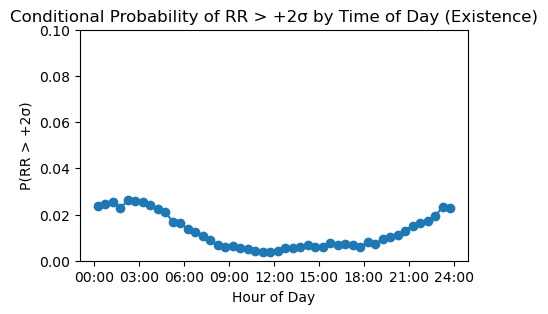

In [7]:
# 1) Decode to hours (0=midnight, 12=noon)
theta = np.arctan2(train['tod_sin'], train['tod_cos']) % (2*np.pi)
hours = (theta / (2*np.pi)) * 24
train = train.assign(tod_hours=hours)

# 1) Bin time (T bins across 24h) and HR (H bins across min..max)
T, H = 48, 100
t_edges = np.linspace(0, 24, T+1)                     # hours
hr_edges = np.linspace(train.respiration_rate.min(), train.respiration_rate.max(), H+1)

t_idx = np.digitize(train['tod_hours'].to_numpy(), t_edges, right=False) - 1
h_idx = np.digitize(train['respiration_rate'].to_numpy(), hr_edges, right=False) - 1
t_idx = np.clip(t_idx, 0, T-1); h_idx = np.clip(h_idx, 0, H-1)

# global +2σ cutoff
hr_cf = train.respiration_rate.mean() + 2 * train.respiration_rate.std(ddof=0)


# centers of time bins
t_centers = 0.5 * (t_edges[:-1] + t_edges[1:])

# probability within each time bin
prob_cf = np.zeros(T)
for b in range(T):
    m = (t_idx == b)
    if m.any():
        prob_cf[b] = np.mean(train.respiration_rate[m] > hr_cf)
    else:
        prob_cf[b] = np.nan

plt.figure(figsize=(5, 3))
plt.plot(t_centers, prob_cf, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('P(RR > +2σ)')
plt.title('Conditional Probability of RR > +2σ by Time of Day (Existence)')
plt.xticks(np.arange(0, 25, 3), [f'{h:02d}:00' for h in range(0, 25, 3)])
plt.ylim(0, 0.1)
plt.savefig('./figures/DistRR2std.png', dpi=1000, bbox_inches="tight")
plt.savefig('./figures/DistRR2std.svg', bbox_inches="tight")
plt.show()

In [8]:
import numpy as np, pandas as pd

# Assumptions:
# train has columns: 'ds', 'respiration_rate', 'tod_hours', optional 'id'
# Fixed sampling every 5 minutes:
STEP_S = 300.0

# --- knobs ---
ROLL = 1               # rolling window (samples) for smoothing; 1 = no smoothing
USE_MEDIAN = True      # True: rolling median; False: rolling mean
EPS_BPM = 5 #10.0          # hysteresis band: stay in episode if HR >= thr - EPS_BPM
# alternatively, set EPS_BPM=None and use a percentage band:
EPS_PCT = None         # e.g., 0.03 for 3% band; set to None to disable pct

BRIDGE_STEPS = 3       # allow up to this many consecutive "below-band" samples within an episode

# sort
sort_cols = ['ds'] if 'id' not in train.columns else ['id', 'ds']
train = train.sort_values(sort_cols).copy()

# ----- thresholds: population or individual -----
use_individual_thresholds = ('id' in train.columns)
if use_individual_thresholds:
    stats = train.groupby('id')['respiration_rate'].agg(['mean','std']).rename(
        columns={'mean':'mu','std':'sigma'}
    )
    stats['thr'] = stats['mu'] + 2*stats['sigma']
    train = train.merge(stats['thr'], left_on='id', right_index=True, how='left')
else:
    thr_global = train['respiration_rate'].mean() + 2*train['respiration_rate'].std(ddof=0)
    train['thr'] = thr_global

def smooth_series(x, roll=ROLL):
    if roll <= 1:
        return x.to_numpy()
    if USE_MEDIAN:
        return x.rolling(roll, center=True, min_periods=1).median().to_numpy()
    else:
        return x.rolling(roll, center=True, min_periods=1).mean().to_numpy()

def compute_episodes_fuzzy(df):
    """
    Fuzzy dwell detection with smoothing + hysteresis + gap bridging
    Returns: start_ds, end_ds, duration_s, start_hour, (id)
    """
    ds = df['ds'].to_numpy()
    hr = smooth_series(df['respiration_rate'])

    thr = df['thr'].to_numpy()
    if EPS_BPM is not None:
        band_lo = thr - EPS_BPM
    elif EPS_PCT is not None:
        band_lo = thr * (1.0 - EPS_PCT)
    else:
        band_lo = thr  # fallback to strict

    above_enter = hr >= thr           # condition to START an episode
    above_stay  = hr >= band_lo       # condition to CONTINUE an episode

    # build episodes with hysteresis + gap bridging
    out = []
    in_ep = False
    below_run = 0
    start_idx = None

    for i in range(len(df)):
        if not in_ep:
            if above_enter[i]:
                in_ep = True
                start_idx = i
                below_run = 0
        else:
            if above_stay[i]:
                below_run = 0
            else:
                below_run += 1
                if below_run > BRIDGE_STEPS:
                    # close episode at i-1
                    end_idx = i - 1
                    n_steps = end_idx - start_idx + 1
                    duration_s = n_steps * STEP_S
                    row = {
                        'start_ds': int(ds[start_idx]),
                        'end_ds':   int(ds[end_idx]),
                        'duration_s': float(duration_s),
                        'start_hour': float(df['tod_hours'].iloc[start_idx] % 24)
                    }
                    if 'id' in df.columns:
                        row['id'] = df['id'].iloc[start_idx]
                    out.append(row)
                    in_ep = False
                    start_idx = None
                    below_run = 0

    # close tail episode if still open
    if in_ep and start_idx is not None:
        end_idx = len(df) - 1
        n_steps = end_idx - start_idx + 1
        duration_s = n_steps * STEP_S
        row = {
            'start_ds': int(ds[start_idx]),
            'end_ds':   int(ds[end_idx]),
            'duration_s': float(duration_s),
            'start_hour': float(df['tod_hours'].iloc[start_idx] % 24)
        }
        if 'id' in df.columns:
            row['id'] = df['id'].iloc[start_idx]
        out.append(row)

    return pd.DataFrame(out)

# apply per-id if present
if use_individual_thresholds:
    episodes = (
        train.groupby('id', group_keys=False)
             .apply(compute_episodes_fuzzy)
             .reset_index(drop=True)
    )
else:
    episodes = compute_episodes_fuzzy(train)

# ---------- summarize by hour (same as before) ----------
T = 48
t_edges = np.linspace(0, 24, T+1)
t_centers = 0.5 * (t_edges[:-1] + t_edges[1:])

def bin_index(hours):
    idx = np.digitize(hours, t_edges, right=False) - 1
    return np.clip(idx, 0, T-1)

episodes['t_bin'] = bin_index(episodes['start_hour'])

def summarize_bin(group):
    d = group['duration_s']
    return pd.Series({
        'n_episodes': int(len(d)),
        'mean_min': float(d.mean()/60) if len(d) else np.nan,
        'median_min': float(d.median()/60) if len(d) else np.nan,
        'p90_min': float(d.quantile(0.90)/60) if len(d) else np.nan,
        'frac_ge_10min': float((d >= 10*60).mean()) if len(d) else np.nan,
        'frac_ge_30min': float((d >= 30*60).mean()) if len(d) else np.nan,
        'frac_ge_60min': float((d >= 60*60).mean()) if len(d) else np.nan,
    })

dwell_summary = (
    episodes.groupby('t_bin')
            .apply(summarize_bin)
            .reindex(range(T))
            .reset_index(drop=True)
)
dwell_summary['hour_center'] = t_centers

/tmp/ipykernel_48315/78796980.py:147: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_bin)


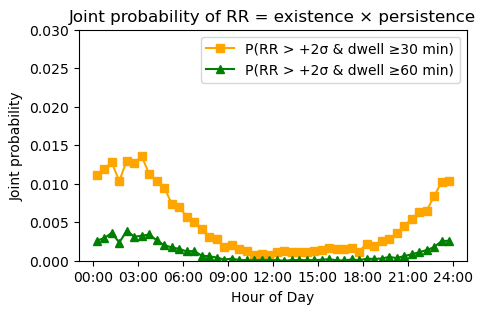

In [9]:
# joint probability for ≥30 and ≥60 min
joint_30 = prob_cf * dwell_summary['frac_ge_30min'].to_numpy()
joint_60 = prob_cf * dwell_summary['frac_ge_60min'].to_numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(dwell_summary['hour_center'], joint_30, color='orange', marker='s', label='P(RR > +2σ & dwell ≥30 min)')
plt.plot(dwell_summary['hour_center'], joint_60, color='green', marker='^', label='P(RR > +2σ & dwell ≥60 min)')

plt.xlabel('Hour of Day')
plt.ylabel('Joint probability')
#plt.title('Final Distribution: Joint Probability of HR > +2σ and Long Dwell')
plt.title('Joint probability of RR = existence × persistence')
plt.xticks(range(0,25,3), [f'{h:02d}:00' for h in range(0,25,3)])
plt.ylim(0, 0.03)
plt.legend()
plt.savefig('./figures/JointRR2std.png', dpi=1000, bbox_inches="tight")
plt.savefig('./figures/JointRR2std.svg', bbox_inches="tight")
plt.show()


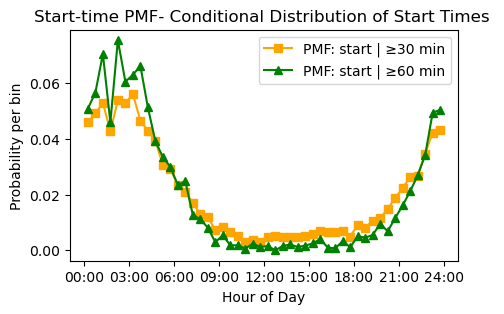

In [10]:
bin_width_h = 24.0 / len(joint_30)   # e.g. 0.5 h if 48 bins

# Normalize to PMF (sums to 1)
pmf_30 = joint_30 / np.nansum(joint_30)
pmf_60 = joint_60 / np.nansum(joint_60)

# Or density (area = 1 over 24 h)
density_30 = pmf_30 / bin_width_h
density_60 = pmf_60 / bin_width_h

# Plot normalized PMF
plt.figure(figsize=(5,3))
plt.plot(dwell_summary['hour_center'], pmf_30, color='orange', marker='s',
         label='PMF: start | ≥30 min')
plt.plot(dwell_summary['hour_center'], pmf_60, color='green', marker='^',
         label='PMF: start | ≥60 min')
plt.xlabel('Hour of Day'); plt.ylabel('Probability per bin')
plt.title('Start-time PMF- Conditional Distribution of Start Times ')
plt.xticks(range(0,25,3), [f'{h:02d}:00' for h in range(0,25,3)])
plt.legend()
plt.savefig('./figures/PMFRR2std.png', dpi=1000, bbox_inches="tight")
plt.savefig('./figures/PMFRR2std.svg', bbox_inches="tight")
plt.show()